In [3]:
%matplotlib inline

In [4]:
from matplotlib import pyplot as plt

In [5]:
from scipy import ndimage
from thllib import flylib
import numpy as np
import h5py
import cv2
import sys
from scipy.stats import vonmises
from scipy import convolve

In [6]:
flynum = 1337 #sys.argv[0]#

In [7]:
###### parameters ######
light_on_thresh = 10 #threshold to use to find the begining of experiment. Average pixel value.
flash_offset = 50 #deal with the fact that the camera is over-exposed when the light first comes on
angles = np.linspace(0,360,360*2)[:-1] #resoluton of the angular tracking, larger values yeald slower tracking


In [8]:
fly = flylib.NetFly(flynum)
fly.open_signals('hdf5')

In [9]:
def rotate_image(image, angle,center = None):
    row,col = image.shape
    if center is None:
        center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col,row),borderMode = cv2.BORDER_REPLICATE)
    return new_image

In [10]:
captured_frames = np.squeeze(np.argwhere(np.array(fly.avepxl)>light_on_thresh))
first_frame = fly.images[captured_frames[0]+flash_offset]
center = (first_frame.shape[0]/2,first_frame.shape[1]/2)

In [110]:
def imgfilter(img,order = 3,gw = 0.1):
    gpyr = cv2.pyrDown(img)
    for i in range(order):
        gpyr = cv2.pyrDown(gpyr)
    lpyr = gpyr - cv2.pyrDown(cv2.pyrUp(gpyr))#cv2.Laplacian(gpyr.astype(np.uint8),cv2.CV_8U)
    return np.hstack((gpyr.ravel()*gw,lpyr.ravel()*(1-gw)))#gpyr,lpyr#np.hstack((gpyr.ravel()*gw,lpyr.ravel()*(1-gw)))

In [111]:
template = list()
for i in angles:
    template.append(imgfilter(rotate_image(first_frame,i,center = center)))

In [112]:
import time
class timer():
    def __init__(self):
        self.last_time = time.time()
    
    def dt(self):
        now = time.time()
        dt = now - self.last_time
        self.last_time = now
        return dt

frame_size = len(first_frame.ravel())

tmr = timer()
#imt = img_trim
orientations = list()
correlations = list()
load_image = list()
dot_product = list()
rest_of_loop = list()

for idx in captured_frames[:2000]:
    im = imgfilter(fly.images[idx])
    load_image.append(tmr.dt())
    corvals = [np.dot(t,im) for t in template]
    #corvals = [np.dot(t.ravel()[sel],im[sel]) for t in template]
    dot_product.append(tmr.dt())
    tidx = np.argmax(corvals)
    correlations.append(corvals)
    orientations.append(angles[tidx])
    if not((idx%200)>0):
        from IPython import display
        print idx,angles[tidx]
    rest_of_loop.append(tmr.dt())

200 0.500695410292
400 22.5312934631
600 36.5507649513
800 16.5229485396
1000 7.51043115438
1200 345.479833102
1400 356.995827538
1600 297.913769124
1800 36.050069541
2000 355.493741307


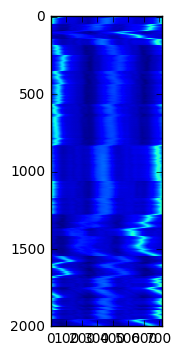

In [113]:
plt.imshow(correlations)

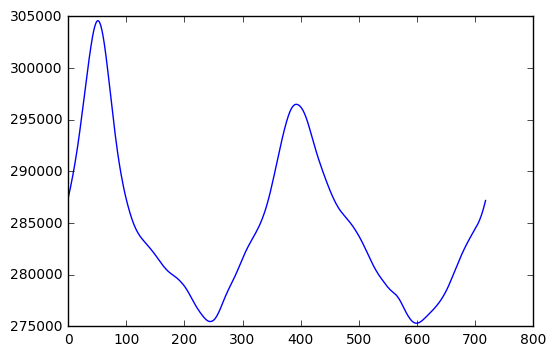

In [114]:
plt.plot(correlations[10])

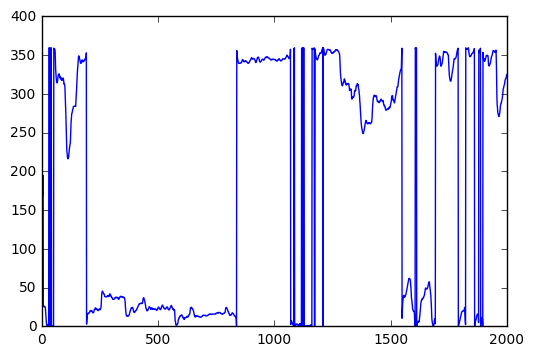

In [115]:
plt.plot(orientations)

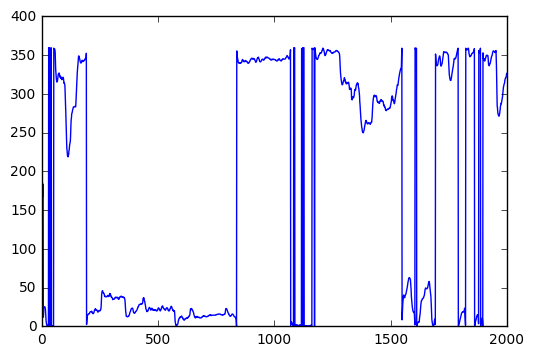

In [15]:
plt.plot(orientations)
#plt.twinx()
#plt.plot(np.max(correlations,axis =1),color = 'r')

In [ ]:
from scipy import ndimage
from thllib import flylib
import numpy as np
import h5py
import cv2
import sys
from scipy.stats import vonmises
from scipy import convolve
#from matplotlib import pyplot as plt

flynum = 1337 #sys.argv[0]#

###### parameters ######
light_on_thresh = 10 #threshold to use to find the begining of experiment. Average pixel value.
flash_offset = 50 #deal with the fact that the camera is over-exposed when the light first comes on
angles = np.linspace(0,360,360*2)[:-1] #resoluton of the angular tracking, larger values yeald slower tracking

fly = flylib.NetFly(flynum)
fly.open_signals('hdf5')

def rotate_image(image, angle,center = None):
    row,col = image.shape
    if center is None:
        center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col,row),borderMode = cv2.BORDER_REPLICATE)
    return new_image

captured_frames = np.squeeze(np.argwhere(np.array(fly.avepxl)>light_on_thresh))

first_frame = fly.images[captured_frames[0]+flash_offset]

center = (first_frame.shape[0]/2,first_frame.shape[1]/2)

template = list()
for i in angles:
    template.append(cv2.pyrDown(cv2.pyrDown(rotate_image(first_frame,i,center = center))))

import time
class timer():
    def __init__(self):
        self.last_time = time.time()
    
    def dt(self):
        now = time.time()
        dt = now - self.last_time
        self.last_time = now
        return dt

frame_size = len(first_frame.ravel())

tmr = timer()
#imt = img_trim
orientations = list()
correlations = list()

load_image = list()
dot_product = list()
rest_of_loop = list()

for idx in captured_frames[:2000]:
    im = cv2.pyrDown(cv2.pyrDown(fly.images[idx])).ravel()
    load_image.append(tmr.dt())
    corvals = [np.dot(t.ravel(),im) for t in template]
    #corvals = [np.dot(t.ravel()[sel],im[sel]) for t in template]
    dot_product.append(tmr.dt())
    tidx = np.argmax(corvals)
    correlations.append(corvals)
    orientations.append(angles[tidx])
    if not((idx%200)>0):
        from IPython import display
        #display.clear_output(wait=True)
        #plt.subplot(1,2,1)
        #plt.imshow(template[tidx])
        #plt.subplot(1,2,2)
        #plt.imshow(fly.images[idx])
        #display.display(plt.gcf())
        print idx,angles[tidx]
    rest_of_loop.append(tmr.dt())

fly.save_hdf5(np.array(orientations),'orientations')
fly.save_hdf5(np.array(correlations),'correlations')
fly.save_hdf5(np.array(load_image),'profile_load_image')
fly.save_hdf5(np.array(dot_product),'profile_dot_product')
fly.save_hdf5(np.array(rest_of_loop),'rest_of_loop')

In [18]:
fly.orientations

[356.89913864962489,
 356.89913864962489,
 356.89913864962489,
 356.89913864962489,
 356.89913864962489,
 356.89913864962489,
 356.79911086412892,
 356.79911086412892,
 356.79911086412892,
 352.89802722978607,
 352.7979994442901,
 352.7979994442901,
 352.7979994442901,
 352.7979994442901,
 352.7979994442901,
 353.098082800778,
 352.89802722978607,
 352.89802722978607,
 354.79855515420951,
 354.79855515420951,
 356.79911086412892,
 356.99916643512086,
 356.79911086412892,
 356.89913864962489,
 357.09919422061682,
 357.09919422061682,
 357.09919422061682,
 357.69936093359269,
 357.09919422061682,
 357.09919422061682,
 357.19922200611279,
 357.99944429008059,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 357.99944429008059,
 357.99944429008059,
 357.99944429008059,
 357.09919422061682,
 357.99944429008059,
 0.0,
 357.99944429008059,
 357.69936093359269,
 357.99944429008059,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

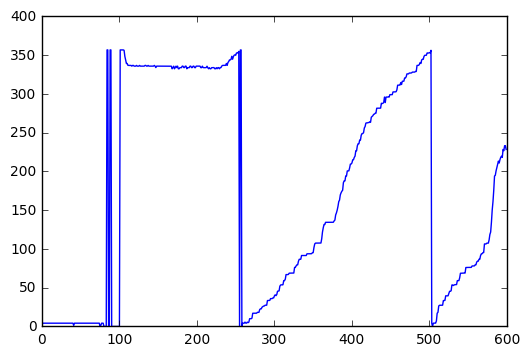

In [20]:
plt.plot(orientations[10300:10900])
#plt.gca().set_xbound(10300,10400)

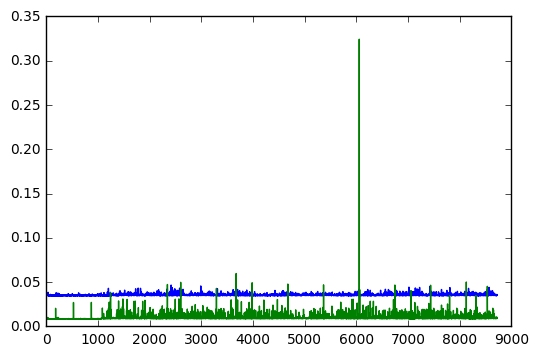

In [48]:
plt.plot(dot_product)
plt.plot(load_image)

In [474]:
vel_kappa = 0.5 #vonmises kappa applied to velocity prediction in baysian filter, higher values will favor slow transitions.
state_kappa = 0.01

vel_kernel = vonmises.pdf(np.deg2rad(angles)-np.pi,vel_kappa)
vel_kernel /= np.sum(vel_kernel)
state_kernel = vonmises.pdf(np.deg2rad(angles)-np.pi,state_kappa)
state_kernel /= np.sum(state_kernel)

In [475]:
def predict(state_pdf,velocity,kernel):
    p = convolve(np.roll(state_pdf, velocity), kernel, mode='wrap')
    return p/np.sum(p)

In [476]:
def estimate_state(prediction,observation,kernel):
    posterior = observation*prediction
    peak = np.argmax(posterior)
    descision = np.roll(kernel,peak-(len(kernel)/2))
    return descision

In [477]:
def wraped_descrete_vel(l0,l1):
    x0 = np.argmax(l0)
    x1 = np.argmax(l1)
    v1 = x1-x0
    v2 = len(angles) - x0 + x1
    v3 = x0 + len(angles) - x1
    v = np.array([v1,v2,v3])
    return v[np.argmin(np.abs(v))]

In [481]:
state_estimates = list()
velocities = list()
predictions = list()

idx_0 = 1650
l0 = correlations[idx_0]
l1 = correlations[idx_0+1]
v = wraped_descrete_vel(l0,l1)
predictions.append(predict(l1/np.sum(l1),v,vel_kernel))
state_estimates.append(estimate_state(predictions[-1],correlations[idx_0+2],state_kernel))
velocities.append(wraped_descrete_vel(11/np.sum(l1),state_estimates[-1]))
for i in range(60):
    predictions.append(predict(state_estimates[-1],velocities[-1],vel_kernel))
    state_estimates.append(estimate_state(predictions[-1],correlations[idx_0+2+i],state_kernel))
    velocities.append(wraped_descrete_vel(state_estimates[-2],state_estimates[-1]))